<p align="center">
    <a href="https://predict-idlab.github.io/landmarker">
        <img alt="landmarker" src="https://raw.githubusercontent.com/predict-idlab/landmarker/main/docs/_static/images/logo.svg" width="66%">
    </a>
</p>

# Training and Evaluating Adaptive Heatmap Regression Model for Landmark Detection with ISBI 2015 Cephalometric X-ray Dataset

In this tutorial, we will train and evaluate an adaptive heatmap regression model for landmark 
detection with the ISBI 2015 Cephalometric X-ray dataset. The ISBI 2015 Cephalometric X-ray dataset
is a dataset of 2D cephalometric X-rays. The dataset contains 400 images, each with 19 landmarks
annotated. The dataset is split into a training set of 150 images and two test sets of 150 and
100 images respectively.

We will go through the following steps:
* [Loading the dataset](#Loading-the-dataset)
* [Constructing a heatmap generator](#Constructing-a-heatmap-generator)
* [Inspecting the dataset](#Inspecting-the-dataset)
* [Training and initializing the SpatialConfiguration model](#Training-the-model)
* [Evaluating the model](#Evaluating-the-model)

<a target="_blank" href="https://colab.research.google.com/github/predict-idlab/landmarker/examples/2D-example-ISBI2015-adaptive-heatmap-regression.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Setup environment

In [1]:
# !python -c "import landmarker" || pip install landmarker

import sys
import os

sys.path.append("../src/")
import landmarker

## Setup imports and variables

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from monai.transforms import (Compose, RandAffined, RandGaussianNoised, RandStdShiftIntensityd,
                              RandScaleIntensityd, RandAdjustContrastd, RandHistogramShiftd,
                              ScaleIntensityd, Lambdad)
from tqdm.notebook import tqdm

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

## Loading the dataset

### Short description of the data and dataset module
The [landmarker](https://github.com/predict-idlab/landmarker) package has several built-in
datasets in the `landmarker.datasets` module, as well as utility classes for building your own
datasets in the `landmarker.data` module. There are three types of datasets: 'LandmarkDataset',
'HeatmapDataset', and 'MaskDataset'. The 'LandmarkDataset' is a dataset of images with landmarks,
the 'HeatmapDataset' is a dataset of images with heatmaps, and the 'MaskDataset' is a dataset of
images with masks (i.e., binary segmentation masks indiciating the location of the landmarks). The 
'HeatmapDataset' and 'MaskDataset' both inherit from the 'LandmarkDataset' class, and thus also 
contain information about the landmarks. The 'MaskDataset' can be constructed from specified image 
and landmarks pairs, or from images and masks pairs, because often that is how the data is
distributed. The 'HeatmapDataset' can be constructed from images and landmarks pairs.

Images can be provided as a list of paths to stored images, or as a a numpy arary, torch tensor, 
list of numpy  arrays or list of torch tensors. Landmarks can be as numpy arrays or torch tensors.
These landmarks can be provided in three different shapes: (1) (N, D) where N is the number of
samples and D is the number of dimensions, (2) (N, C, D) where C is the number of landmark
classes, (3) (N, C, I, D) where I is the number of instances per landmark class, if less than I
instances are provided, the remaining instances are filled with NaNs.

For built-in datasets, the `landmarker.datasets` module provides a function for
downloading and loading the dataset, e.g. `get_cepha_landmark_datasets` for the ISBI 2015 
Cephalometric X-ray dataset. Most of these functions take the same arguments, namely `path_dir`,
some are dataset specific. The `path_dir` argument specifies the directory where the dataset is
downloaded to, or loaded from if it is already downloaded. For most datasets multiple functions
are provided for getting different types of datasets. For example, the ISBI 2015 Cephalometric
X-ray dataset has the following functions: `get_cepha_landmark_datasets` and 
`get_cepha_heatmap_datasets`.

### Download and load ISBI 2015 landmark dataset
The ISBI 2015 Cephalometric X-ray dataset is a dataset of 2D cephalometric X-ray images with 19
landmarks. The dataset is split into a training set of 150 images and two test sets, where test
set  1 contains 150 images and test set 2 contains 100 images. When loading the dataset, you can
also specify a transform function, which is applied to the images and landmarks of the training
set. Currently, we only support the `monai.transforms.ComposeD transform, which allows you to
compose multiple transforms. The `monai.transforms` module contains many useful transforms, such
as `RandomAffine` and `NormalizeIntensity`. The transforms must be dictionary transforms, i.e.,
they must return a dictionary with the keys 'image' and ('seg'), in the case of heatmap and mask
regression.

In [4]:
from landmarker.transforms.images import UseOnlyFirstChannel
fn_keys = ('image',)
spatial_transformd = [RandAffined(fn_keys, prob=1,
                        rotate_range=(-np.pi/12, np.pi/12),
                        translate_range=(-10, 10),
                        scale_range=(-0.1, 0.1),
                        shear_range=(-0.1, 0.1)
                        )]

train_transformd = Compose([
                            UseOnlyFirstChannel(('image', )),
                            ScaleIntensityd(('image', )),  # Scale intensity
                            RandGaussianNoised(('image', ), prob=0.2, mean=0, std=0.1),  # Add gaussian noise
                            RandScaleIntensityd(('image', ), factors=0.25, prob=0.2),  # Add random intensity scaling
                            RandAdjustContrastd(('image', ), prob=0.2, gamma=(0.5,4.5)),  # Randomly adjust contrast
                            RandHistogramShiftd(('image', ), prob=0.2),  # Randomly shift histogram
                            ScaleIntensityd(('image', )),  # Scale intensity
                        ] + spatial_transformd)

inference_transformd = Compose([
    UseOnlyFirstChannel(('image', )),
    ScaleIntensityd(('image', )),
])

In [5]:
from landmarker.datasets import get_cepha_landmark_datasets

data_dir = "../../data"
ds_train, ds_test1, ds_test2 = get_cepha_landmark_datasets(data_dir, train_transform=train_transformd,
                                                           inference_transform=inference_transformd,
                                                           store_imgs = True, dim_img=(512, 512),
                                                           junior = False, single_dataset = False)

Reading 150 images...


100%|██████████| 150/150 [04:06<00:00,  1.64s/it]


Resizing 150 images and landmarks...


100%|██████████| 150/150 [00:30<00:00,  4.88it/s]


Reading 150 images...


100%|██████████| 150/150 [02:41<00:00,  1.07s/it]


Resizing 150 images and landmarks...


100%|██████████| 150/150 [00:34<00:00,  4.38it/s]


Reading 100 images...


100%|██████████| 100/100 [00:30<00:00,  3.32it/s]


Resizing 100 images and landmarks...


100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


## Constructing a heatmap generator
The heatmap generator is a class that generates heatmaps from landmarks. It is used to generate
heatmaps from the landmarks of the training set, which are then used to train the model. The
`landmarker.heatmap_generator` module contains several heatmap generators, such as the
`GaussianHeatmapGenerator` and `LaplaceHeatmapGenerator` which generate a multivariate 
Gaussian and Laplace distribution respectively. The HeatmapGenerator subclasses take the following
arguments:
* `sigmas`: the standard deviation of the Gaussian distribution, or the scale of the Laplace. This 
could be a scalar, or a list of scalars, one for each landmark class. Additionally, it could be a
covariance matrix, or a list of covariance matrices, one for each landmark class.
* `gamma`: If provided, the heatmaps are scaled by `gamma` before being returned.
* `rotation`: If provided, the heatmaps are rotated by `rotation` before being returned.
* `heatmap_size`: The size of the returned heatmaps.
* learnable: If True, the `sigma` and `rotation` parameters are learnable parameters, and thus
will be optimized during training.
* `background`: A boolean indicating whether to add a background class to the heatmaps. If True,
the heatmaps will have an additional channel, which is 1 everywhere except at the location of the
landmarks, where it is 0. The background class is the first class, i.e., the first channel.
* `all_points`: A boolean indicating whether to add a channel with all the landmarks. If True, the
heatmaps will have an additional channel, which is 1 at the location of the landmarks, and 0.
everywhere else.
* `continuous`: A boolean indicating whether to use continuous or discrete landmarks.
* `device`: The device on which the heatmaps are generated.

The landmarks provide to the heatmap generator must be a torch.Tensor and can be in three different 
shapes: (1) (N, D) where N is the number of samples and D is the number of dimensions, (2) (N, C, D)
where C is the number of landmark classes, (3) (N, C, I, D) where I is the number of instances per
landmark class, if less than I instances are provided, the remaining instances are filled with NaNs.
The heatmap generator will return a torch.Tensor of shape (N, C, H, W), where H and W are the height
and width of the heatmaps respectively.

**Note that with 2D landmarks the y coordinates are the first dimension, and the x coordinates are the
second dimension.**

In [6]:
from landmarker.heatmap.generator import GaussianHeatmapGenerator

heatmap_generator = GaussianHeatmapGenerator(
    nb_landmarks=19,
    sigmas=3,
    gamma=100,
    heatmap_size=(512, 512),
    learnable=True, # If True, the heatmap generator will be trainable
)

## Inspecting the dataset

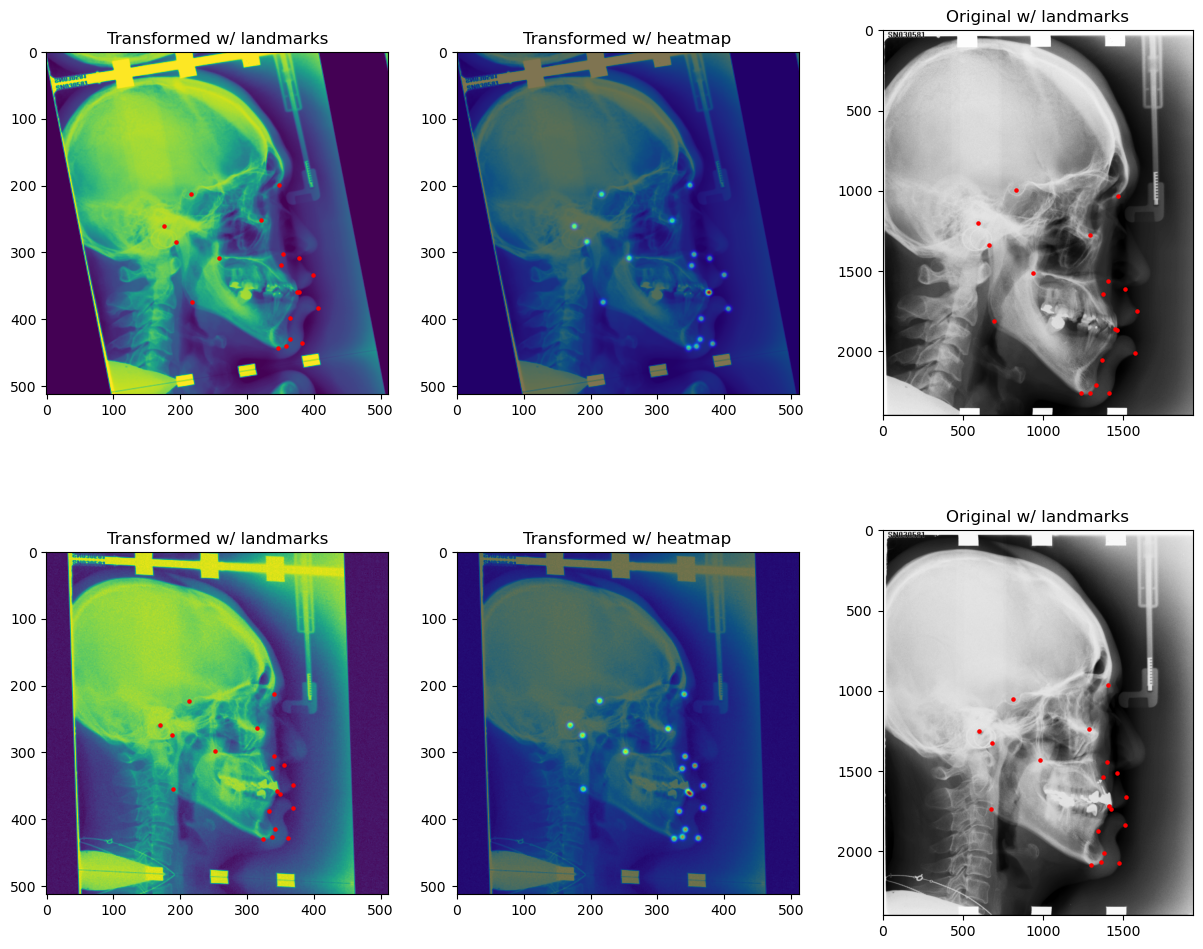

In [7]:
from landmarker.visualize import inspection_plot

# Plot the first 3 images from the training set
inspection_plot(ds_train, range(2), heatmap_generator=heatmap_generator, save_path="landmarker_inspect_example.pdf")

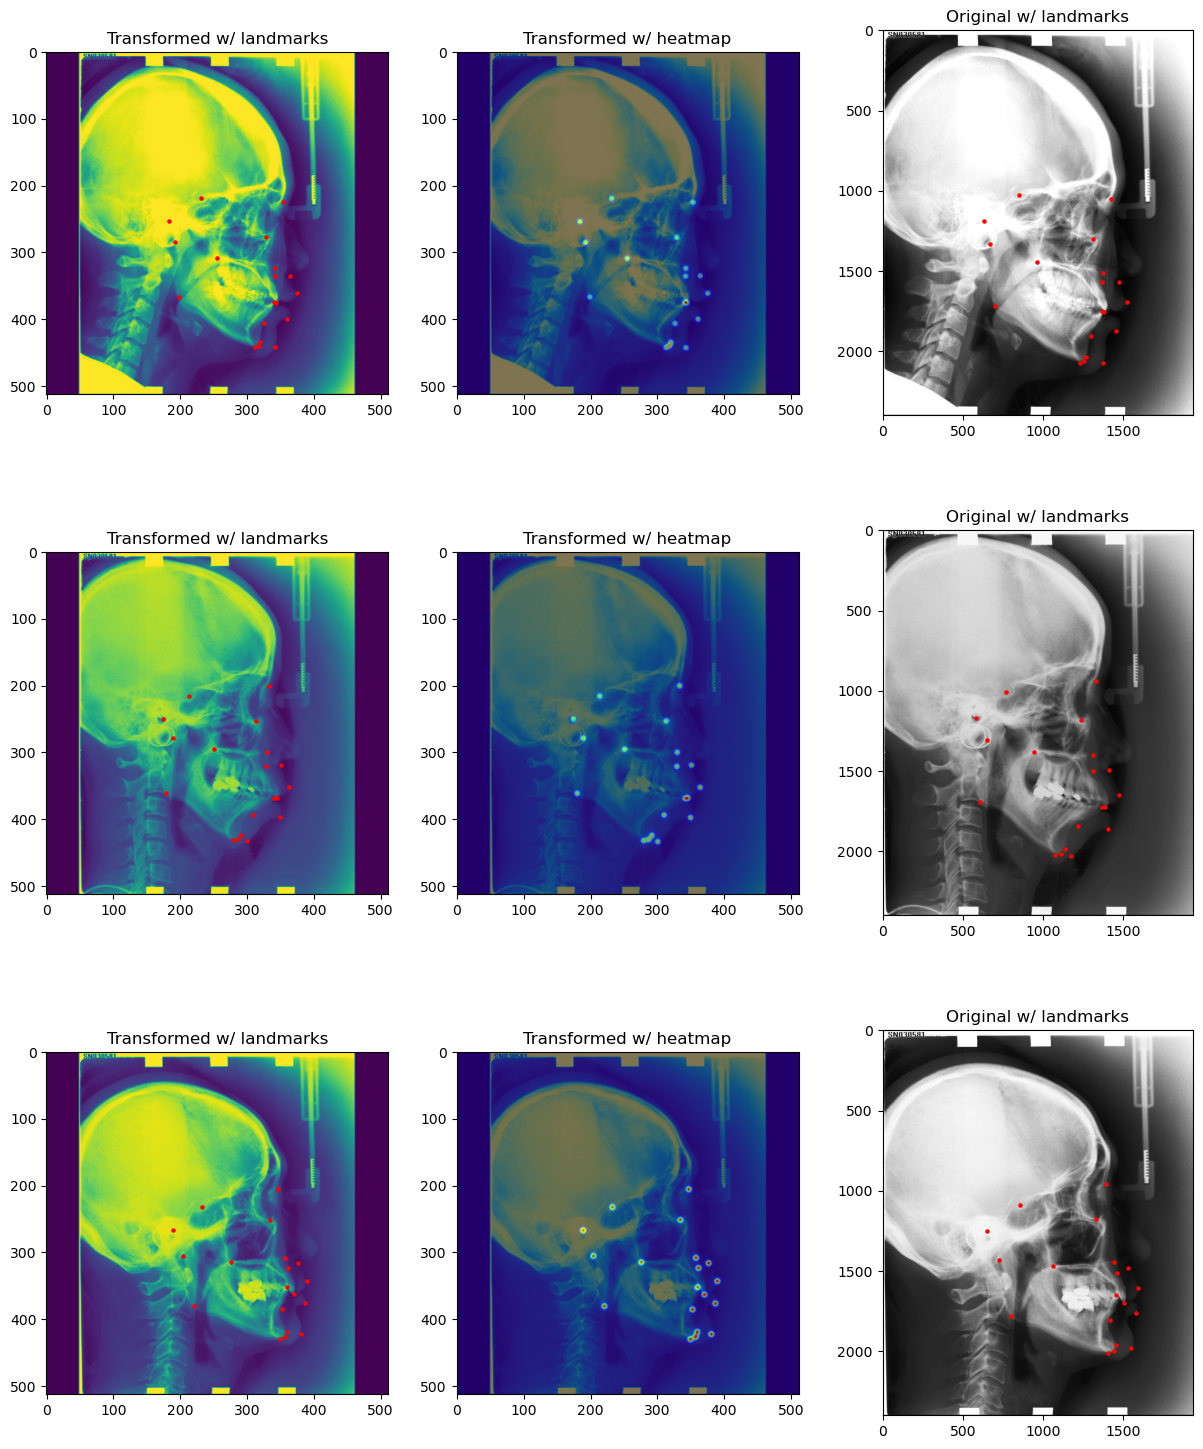

In [8]:
# Plot the first 3 images from dataset without transforms
inspection_plot(ds_test1, range(3), heatmap_generator=heatmap_generator)

## Training and initializing the SpatialConfiguration model

### Initializing the model, optimizer and loss function

In [9]:
from landmarker.models.spatial_configuration_net import OriginalSpatialConfigurationNet
from landmarker.losses import GaussianHeatmapL2Loss

model = OriginalSpatialConfigurationNet(in_channels=1, out_channels=19).to(device)
print("Number of learnable parameters: {}".format(
    sum(p.numel() for p in model.parameters() if p.requires_grad)))
lr = 1e-6
batch_size = 1
epochs = 200

optimizer = torch.optim.SGD([
    {'params': model.parameters(), "weight_decay":1e-3},
    {'params': heatmap_generator.sigmas},
    {'params': heatmap_generator.rotation}]
    , lr=lr, momentum=0.99, nesterov=True)


criterion = GaussianHeatmapL2Loss(
    alpha=5
)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                          patience=10, cooldown=10)

Number of learnable parameters: 6181030


### Setting the data loaders

In [10]:
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=5)
val_loader = DataLoader(ds_test1, batch_size=batch_size, shuffle=False, num_workers=5)
test_loader = DataLoader(ds_test2, batch_size=batch_size, shuffle=False, num_workers=5)

### Training the model

In [11]:
from landmarker.heatmap.decoder import heatmap_to_coord
from landmarker.metrics import point_error

def train_epoch(model, heatmap_generator, train_loader, criterion, optimizer, device):
    running_loss = 0
    model.train()
    for i, batch in enumerate(tqdm(train_loader)):
        images = batch["image"].to(device)
        heatmaps = heatmap_generator(batch["landmark"]).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, heatmap_generator.sigmas, heatmaps)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10000.0)
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def val_epoch(model, heatmap_generator, val_loader, criterion, device, method="local_soft_argmax"):
    eval_loss = 0
    eval_mpe = 0
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(val_loader)):
            images = batch["image"].to(device)
            outputs = model(images)
            dim_orig = batch["dim_original"].to(device)
            pixel_spacing = batch["spacing"].to(device)
            padding = batch["padding"].to(device)
            heatmaps = heatmap_generator(batch["landmark"]).to(device)
            landmarks = batch["landmark"].to(device)
            loss = criterion(outputs, heatmap_generator.sigmas, heatmaps)
            pred_landmarks = heatmap_to_coord(outputs, method=method)
            eval_loss += loss.item()
            eval_mpe += point_error(landmarks, pred_landmarks, images.shape[-2:], dim_orig,
                                    pixel_spacing, padding, reduction="mean")
    return eval_loss / len(val_loader), eval_mpe / len(val_loader)

def train(model, heatmap_generator, train_loader, val_loader, criterion, optimizer, device, epochs=1000):
    for epoch in tqdm(range(epochs)):
        train_loss = train_epoch(model, heatmap_generator, train_loader, criterion, optimizer, device)
        val_loss, val_mpe = val_epoch(model, heatmap_generator, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f} - Val mpe: {val_mpe:.4f}")
        lr_scheduler.step(val_loss)

In [ ]:
train(model, heatmap_generator, train_loader, val_loader, criterion, optimizer, device,
      epochs=epochs)

In [ ]:
# torch.save(model.state_dict(), "isbi2015-scn-learnable.pt")
# torch.save(heatmap_generator.state_dict(), "isbi2015-scn-heatmap-generator.pt")

## Evaluating the model

In [12]:
# model.load_state_dict(torch.load("isbi2015-scn-learnable.pt", weights_only=True))
# heatmap_generator.load_state_dict(torch.load("isbi2015-scn-heatmap-generator.pt", weights_only=True))

<All keys matched successfully>

In [13]:
pred_landmarks_test1 = []
true_landmarks_test1 = []
dim_origs_test1 = []
pixel_spacings_test1 = []
paddings_test1 = []
test1_mpe = 0
model.eval()
model.to(device)
with torch.no_grad():
    for i, batch in enumerate(tqdm(val_loader)):
        images = batch["image"].to(device)
        outputs = model(images)
        dim_orig = batch["dim_original"].to(device)
        pixel_spacing = batch["spacing"].to(device)
        padding = batch["padding"].to(device)
        landmarks = batch["landmark"].to(device)
        pred_landmark = heatmap_to_coord(outputs, method="local_soft_argmax")
        test1_mpe += point_error(landmarks, pred_landmark, images.shape[-2:], dim_orig,
                                pixel_spacing, padding, reduction="mean")
        pred_landmarks_test1.append(pred_landmark.cpu())
        true_landmarks_test1.append(landmarks.cpu())
        dim_origs_test1.append(dim_orig.cpu())
        pixel_spacings_test1.append(pixel_spacing.cpu())
        paddings_test1.append(padding.cpu())

pred_landmarks_test1 = torch.cat(pred_landmarks_test1)
true_landmarks_test1 = torch.cat(true_landmarks_test1)
dim_origs_test1 = torch.cat(dim_origs_test1)
pixel_spacings_test1 = torch.cat(pixel_spacings_test1)
paddings_test1 = torch.cat(paddings_test1)

test1_mpe /= len(val_loader)

print(f"Test 1 Mean PE: {test1_mpe:.4f}")

  0%|          | 0/150 [00:00<?, ?it/s]

Test 1 Mean PE: 1.2015


In [14]:
pred_landmarks_test2 = []
true_landmarks_test2 = []
dim_origs_test2 = []
pixel_spacings_test2 = []
paddings_test2 = []
test2_mpe = 0
model.eval()
model.to(device)
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        images = batch["image"].to(device)
        outputs = model(images)
        dim_orig = batch["dim_original"].to(device)
        pixel_spacing = batch["spacing"].to(device)
        padding = batch["padding"].to(device)
        landmarks = batch["landmark"].to(device)
        pred_landmark = heatmap_to_coord(outputs, method="local_soft_argmax")
        test2_mpe += point_error(landmarks, pred_landmark, images.shape[-2:], dim_orig,
                                pixel_spacing, padding, reduction="mean")
        pred_landmarks_test2.append(pred_landmark.cpu())
        true_landmarks_test2.append(landmarks.cpu())
        dim_origs_test2.append(dim_orig.cpu())
        pixel_spacings_test2.append(pixel_spacing.cpu())
        paddings_test2.append(padding.cpu())

pred_landmarks_test2 = torch.cat(pred_landmarks_test2)
true_landmarks_test2 = torch.cat(true_landmarks_test2)
dim_origs_test2 = torch.cat(dim_origs_test2)
pixel_spacings_test2 = torch.cat(pixel_spacings_test2)
paddings_test2 = torch.cat(paddings_test2)

test2_mpe /= len(test_loader)

print(f"Test 2 Mean PE: {test2_mpe:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Test 2 Mean PE: 1.5066


In [15]:
from landmarker.metrics import sdr

sdr_test1 = sdr([2.0, 2.5, 3.0, 4.0], true_landmarks=true_landmarks_test1, pred_landmarks=pred_landmarks_test1,
               dim=(512, 512), dim_orig=dim_origs_test1.int(), pixel_spacing=pixel_spacings_test1, padding=paddings_test1)

print("Results on Test 1:")
for key in sdr_test1:
    print(f"SDR for {key}mm: {sdr_test1[key]:.4f}")

Results on Test 1:
SDR for 2.0mm: 84.5263
SDR for 2.5mm: 90.1754
SDR for 3.0mm: 93.4737
SDR for 4.0mm: 97.1579


In [16]:
from landmarker.metrics import sdr

sdr_test2 = sdr([2.0, 2.5, 3.0, 4.0], true_landmarks=true_landmarks_test2, pred_landmarks=pred_landmarks_test2,
               dim=(512, 512), dim_orig=dim_origs_test2.int(), pixel_spacing=pixel_spacings_test2, padding=paddings_test2)
for key in sdr_test2:
    print(f"SDR for {key}mm: {sdr_test2[key]:.4f}")

SDR for 2.0mm: 73.1053
SDR for 2.5mm: 81.3158
SDR for 3.0mm: 86.7368
SDR for 4.0mm: 94.1579


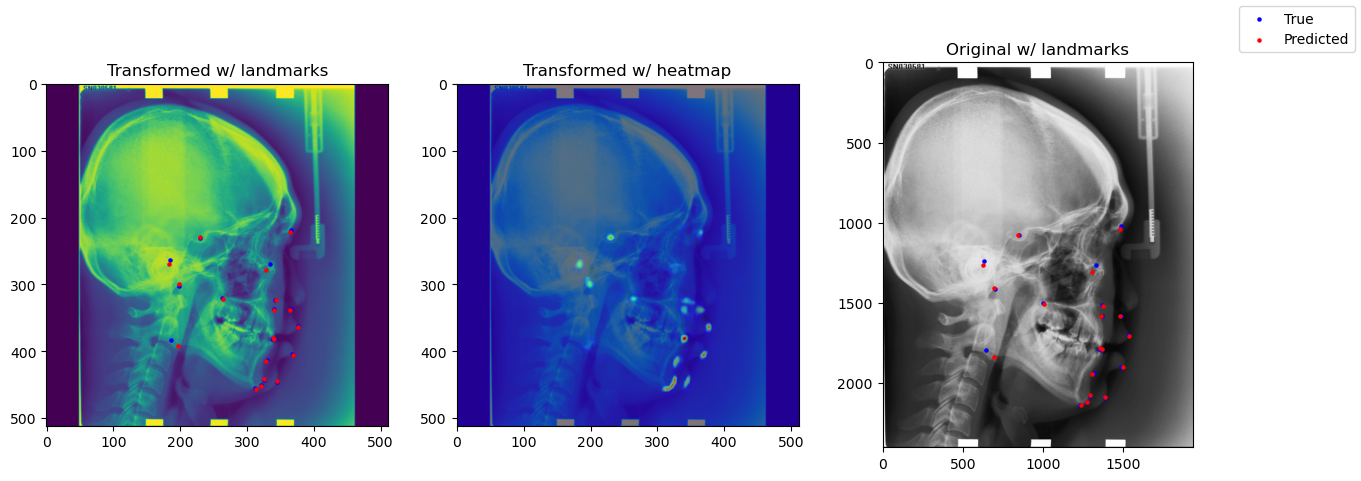

In [17]:
from landmarker.visualize.utils import prediction_inspect_plot

model.eval()
model.to("cpu")
prediction_inspect_plot(ds_test1, model, 5, save_path="pred_inspect_plot_isbi2015.pdf")

In [18]:
from landmarker.visualize import detection_report

print("Test 1")
detection_report(true_landmarks_test1, pred_landmarks_test1, dim=(512, 512), dim_orig=dim_origs_test1.int(),
                    pixel_spacing=pixel_spacings_test1, padding=paddings_test1, class_names=ds_test1.class_names,
                    radius=[2.0, 2.5, 3.0, 4.0], digits=2)

Test 1
Detection report:
1# Point-to-point error (PE) statistics:
Class               Mean      Median    Std       Min       Max       
----------------------------------------------------------------------
landmark_0          0.68      0.53      0.86      0.03      9.35      
landmark_1          1.30      1.01      1.18      0.03      6.81      
landmark_2          1.27      1.02      0.98      0.08      5.42      
landmark_3          1.80      1.32      1.38      0.06      7.31      
landmark_4          1.70      1.55      1.01      0.06      4.44      
landmark_5          1.13      1.00      0.75      0.15      4.01      
landmark_6          0.97      0.76      0.67      0.05      3.56      
landmark_7          0.80      0.62      0.67      0.07      5.45      
landmark_8          0.89      0.69      0.67      0.04      4.32      
landmark_9          2.36      2.05      1.60      0.10      8.29      
landmark_10         0.95      0.74      0.89      0.10      7.05      
landmark_11

In [19]:
from landmarker.visualize import detection_report

print("Test 2")
detection_report(true_landmarks_test2, pred_landmarks_test2, dim=(512, 512), dim_orig=dim_origs_test2.int(),
                    pixel_spacing=pixel_spacings_test2, padding=paddings_test2, class_names=ds_test2.class_names,
                    radius=[2.0, 2.5, 3.0, 4.0], digits=2)

Test 2
Detection report:
1# Point-to-point error (PE) statistics:
Class               Mean      Median    Std       Min       Max       
----------------------------------------------------------------------
landmark_0          0.76      0.55      1.14      0.10      8.84      
landmark_1          0.98      0.69      0.81      0.12      5.09      
landmark_2          2.28      2.21      1.01      0.24      6.66      
landmark_3          1.68      0.94      1.87      0.04      13.14     
landmark_4          1.22      1.08      0.73      0.10      4.33      
landmark_5          2.92      2.98      1.47      0.16      10.12     
landmark_6          0.63      0.54      0.42      0.02      2.22      
landmark_7          0.63      0.50      0.48      0.06      2.68      
landmark_8          0.56      0.48      0.38      0.02      1.58      
landmark_9          1.80      1.61      1.16      0.06      6.60      
landmark_10         1.07      0.75      1.16      0.02      8.65      
landmark_11

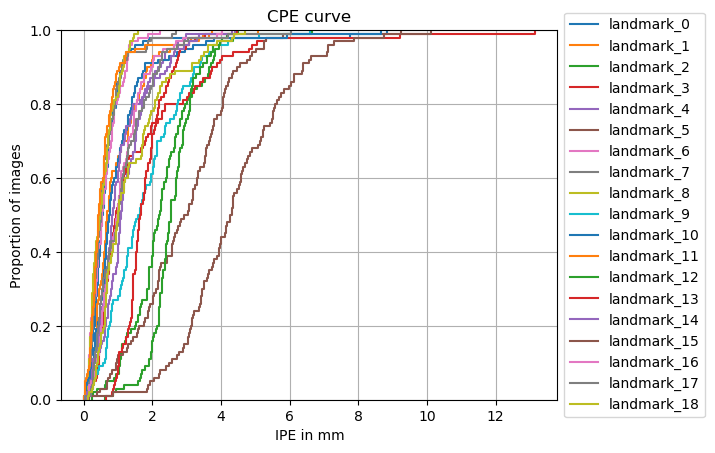

In [20]:
from landmarker.visualize import plot_cpe

plot_cpe(true_landmarks_test2, pred_landmarks_test2, dim=(512, 512), dim_orig=dim_origs_test2.int(),
                    pixel_spacing=pixel_spacings_test2, padding=paddings_test2, class_names=ds_test2.class_names,
                    group=False, title="CPE curve", save_path=None,
                    stat='proportion', unit='mm', kind='ecdf')